In [1]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import datetime
import time
import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer

#from gensim.models import Word2Vec
#from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


stopwords = set(stopwords.words('english'))
symbols   = ['.', ',', '’','“','”','"', "''" ,"'",'*','``', '**','$','%','&','#','-','--',"''",'""','?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"'s","'m","n't"]
stopwords.update(symbols)



def remove_urls (source_text):
    url_reg  = r'[a-z]*[:.]+\S+'
    result   = re.sub(url_reg, '', source_text)
    return result

In [2]:
data = pd.read_csv('./2015-2020-Technology.csv')
data = data.dropna()
data = data.reset_index()
for i in range(len(data)):
    data['selftext'].iloc[i] = remove_urls(data['selftext'].iloc[i])

/Library/Python/3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [3]:
print("Total available data :",len(data))
# filtered_title = []
filtered_content = []
lemmatizer = WordNetLemmatizer()
for title, content in zip(data['title'], data['selftext']):
#     filtered_title.append([lemmatizer.lemmatize(word, pos="n") for word in word_tokenize(title.lower()) if word not in stopwords])
    filtered_content.append([lemmatizer.lemmatize(word, pos="n")  for word in word_tokenize(content.lower()) if word not in stopwords])


Total available data : 3107


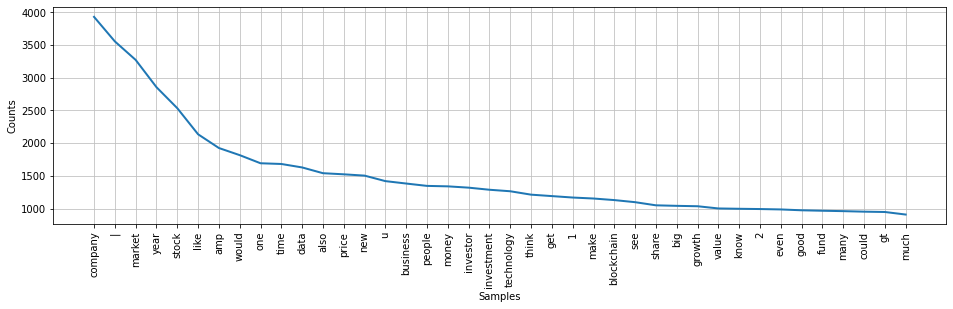

In [4]:
# Word frequency for content
all_filtered_content = sum(filtered_content, [])
fdist_content = nltk.FreqDist(all_filtered_content)
plt.figure(figsize=(16,4))
fdist_content.plot(40,cumulative=False)

In [5]:
df_content = pd.DataFrame.from_dict(fdist_content, orient='index')
df_content.columns = ['Counts']
df_content = df_content.sort_values(by=['Counts'], ascending=False)
df_content.head()

Counts
company    3931
|          3556
market     3273
year       2856
stock      2535

In [6]:
collection = all_filtered_content

In [7]:
for index, eachWord in enumerate(collection):
     if len(eachWord) < 3 or '/' in eachWord or '\'' in eachWord:
            del collection[index]

In [18]:
allContect = []
for arr in filtered_content:
    tmp = []
    for word in arr:
        if (len(word) < 3 or '/' in word):
            continue;
        tmp.append(word)
    allContect.append(tmp)
    print(tmp)
            

['recent', 'post', 'summarized', 'exciting', 'technology', 'look', '2015.', 'link', "'ve", 'summarized', 'technology', 'theme', 'stock', 'currently', 'forefront', 'theme', 'could', 'benefit', 'technology', 'hitting', 'mass', 'market', 'gesture', 'control', 'augmented', 'reality', 'amp', 'object', 'wearable', 'technology', 'wireless', 'capacity', 'specifically', 'speed', 'virtual', 'reality', 'flexible', 'oled', 'display', 'printing', 'printing', 'domestic', 'robot', 'industrial', 'robot', 'medical', 'robot', 'drone']
['printing', 'changing', 'world', 'way', 'behind', 'eight-ball', 'something', 'missing']
['looking', 'option', 'still', 'young', 'would', 'like', 'take', 'advantage', 'youth', 'maybe', 'invest', 'something', 'suggestion']
['read', 'article', 'newspaper', 'today', 'sure', 'think', 'guy', 'experience', 'platform', 'hit', 'shit']
['reading', 'lot', 'printing', 'lately', 'seems', 'getting', 'popular', 'versatile', 'wondering', 'anyone', 'luck', 'friend', 'invest', 'one', 'litt

['removed']
['hope', 'post', 'thought', 'could', 'help', 'like', 'minded', 'entrepreneur', 'part', 'small', 'group', 'focused', 'entrepreneurship', 'self-improvement', 'pure', 'volunteer', 'basis', 'looking', '1-2', 'people', 'dreamer', 'take', 'small', 'step', 'necessary', 'get', 'individual', 'goal', 'group', 'meet', '2nd', '4th', 'sunday', 'month', 'google', 'hangout', 'est', 'mandatory', 'also', 'meet', '1-on-1', 'alternate', 'weekend', 'informally', 'optional', 'get', 'know', 'check', 'give', 'idea', 'group', 'one', 'member', 'ceo', 'ethereum', 'startup', 'competition', 'one', 'biggest', 'startup', 'launch', 'conference', 'going', 'multimillion', 'ico', 'regional', 'sale', 'manager', 'one', 'big', 'telecom', 'company', 'second', 'person', 'coo', 'year', 'veteran', 'legal', 'startup', 'leading', 'group', 'lawyer', 'developed', 'number', 'habit', 'working', 'starting', 'tech', 'startup', 'finished', 'phd', 'top', 'university', 'field', 'fixed', 'sleep', 'schedule', 'sleep', 'wake', 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [8]:
each_words = nltk.FreqDist(collection)
each_words.values()
EachWords = pd.DataFrame.from_dict(each_words, orient='index', columns=['count'])
EachWords = EachWords.sort_values(by=['count'], ascending=False)
temp = EachWords['count'] > 20

In [9]:
temp.value_counts()

False    22881
True      3093
Name: count, dtype: int64

In [10]:
keywords = EachWords[:3041].reset_index()

In [11]:
# 統計原始資料的Title中，關鍵字出現的次數，建立稀疏矩陣
def reddit(text, stopword_list):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word.lower(),pos = 'n') for word in word_tokenize(str(text).lower()) if word not in stopword_list]

data['title_embedded'] = data['selftext'].apply(lambda text:reddit(text, stopwords))

In [12]:
data_list = data['title_embedded']

def creat_matrix(list_):
    output = []
    for i in list(keywords['index']):
        if i in list_:
            count = 0
            for j in list_:
                if j == i:
                    count += 1
            output.append(count)
            continue
        output.append(0)
    return output

In [13]:
data_list1 = data_list.apply(creat_matrix)
data_matrix = pd.DataFrame(list(data_list1), columns=list(keywords['index']))
data_matrix.head()

company  market  year  stock  like  amp  would  one  time  data  ...  \
0        0       1     0      1     0    1      0    0     0     0  ...   
1        0       0     0      0     0    0      0    0     0     0  ...   
2        0       0     0      0     1    0      1    0     0     0  ...   
3        0       0     0      0     0    0      0    0     0     0  ...   
4        0       0     0      0     0    0      0    1     0     0  ...   

   operational  andrew  subsequently  licensing  taxable  announces  \
0            0       0             0          0        0          0   
1            0       0             0          0        0          0   
2            0       0             0          0        0          0   
3            0       0             0          0        0          0   
4            0       0             0          0        0          0   

   ride-hailing  alongside  median  resistance  
0             0          0       0           0  
1             0          0       0           0  
2             0          0       0           0  
3             0          0       0           0  
4             0          0       0           0  

[5 rows x 3041 columns]

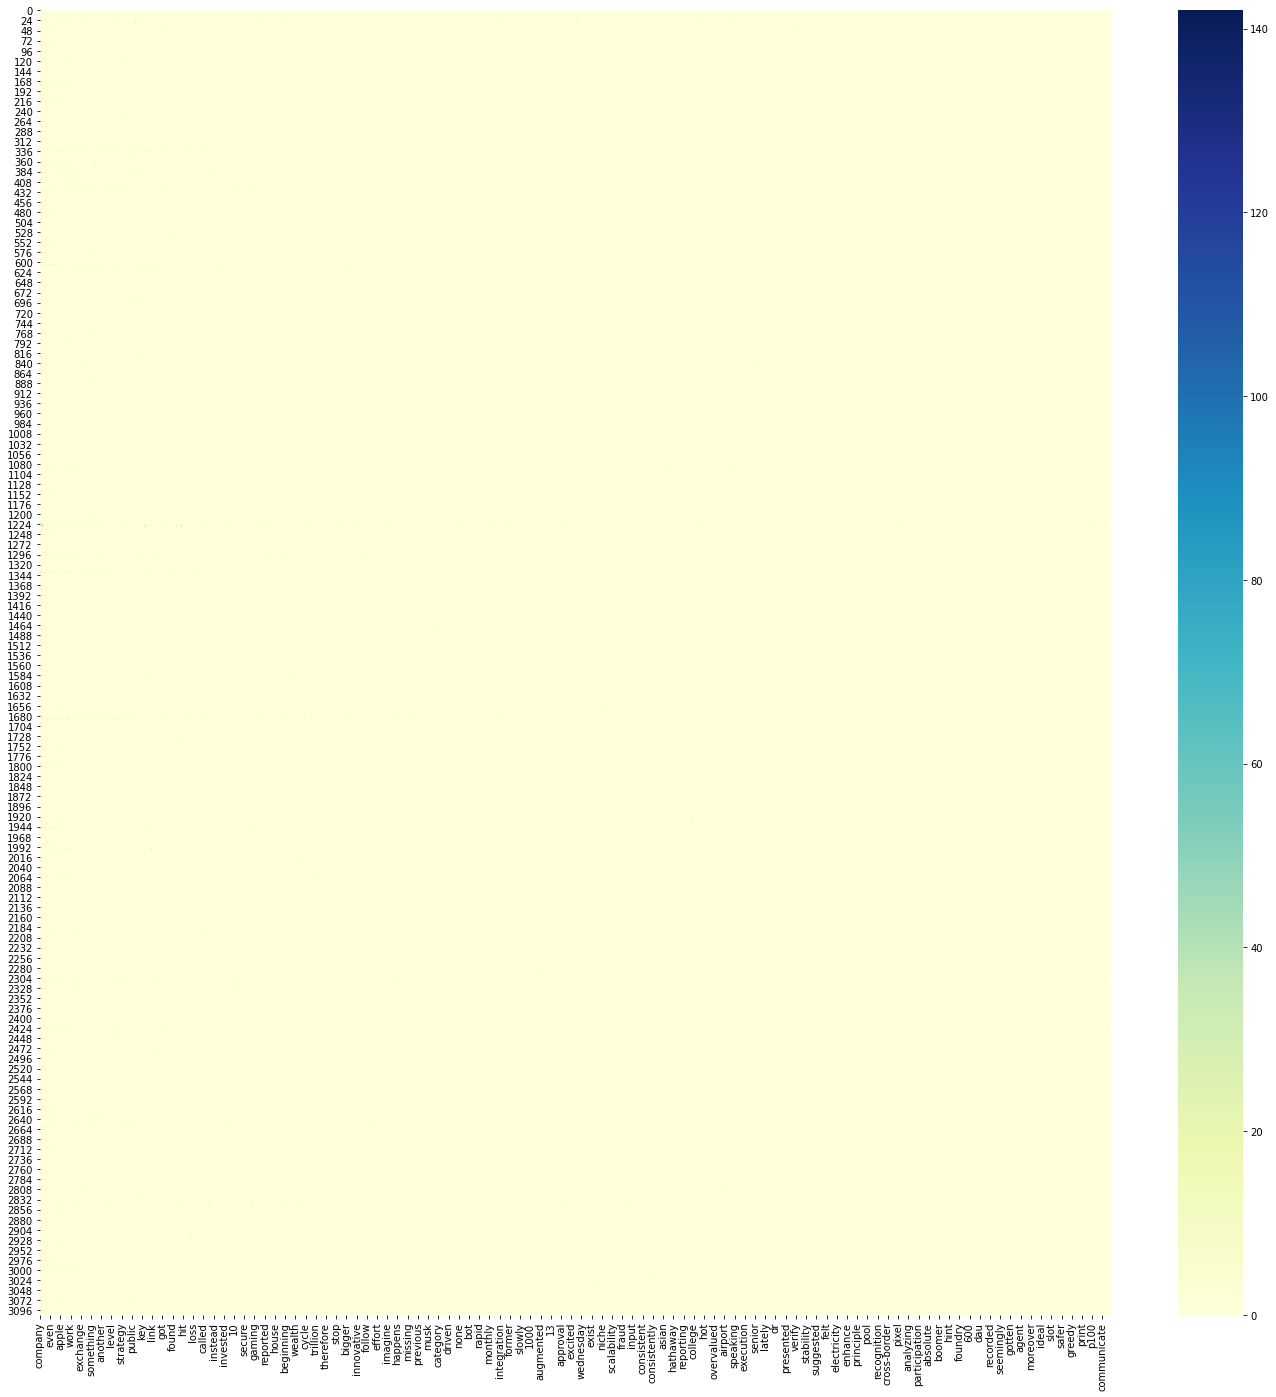

In [14]:
plt.figure(figsize=(24,24))
sns.heatmap(data_matrix, cmap='YlGnBu')
plt.show()

In [15]:
data_matrix_T = data_matrix.transpose()
co_matrix = data_matrix_T.dot(data_matrix)
co_matrix.head()

company  market   year  stock   like    amp  would    one  time  \
company    46295   20218  25005  15057  10782  10960   8875  10074  9916   
market     20218   30219  17854  12347   8788   7570   8579   8055  9974   
year       25005   17854  27266  11588   9437   6605   7100   7868  9314   
stock      15057   12347  11588  21187   6131   6527   5366   4769  6106   
like       10782    8788   9437   6131   9136   3745   5083   4848  5055   

          data  ...  operational  andrew  subsequently  licensing  taxable  \
company  14615  ...          115      43           186        215      463   
market    5028  ...           99      24           153        102      171   
year      7041  ...           87      79            91        117      144   
stock     2075  ...           73      81           158         87      516   
like      2636  ...           43      97            56         52      172   

         announces  ride-hailing  alongside  median  resistance  
company         52           361        127     584          75  
market          28           226        117     215         156  
year            28           278         56     583          78  
stock           10            10         18     193         116  
like             4            86         23     199          58  

[5 rows x 3041 columns]

In [16]:
# 資料正規
co_matrix_norm = np.divide(co_matrix, np.diagonal(co_matrix))
co_matrix_norm.head()

company    market      year     stock      like       amp     would  \
company  1.000000  0.669049  0.917076  0.710672  1.180166  0.613662  0.997303   
market   0.436721  1.000000  0.654808  0.582763  0.961909  0.423852  0.964041   
year     0.540123  0.590820  1.000000  0.546939  1.032947  0.369821  0.797842   
stock    0.325240  0.408584  0.424998  1.000000  0.671081  0.365454  0.602989   
like     0.232898  0.290810  0.346109  0.289376  1.000000  0.209686  0.571188   

              one      time      data  ...  operational    andrew  \
company  1.436066  1.197295  0.778678  ...     5.476190  0.843137   
market   1.148254  1.204298  0.267889  ...     4.714286  0.470588   
year     1.121597  1.124608  0.375140  ...     4.142857  1.549020   
stock    0.679829  0.737262  0.110555  ...     3.476190  1.588235   
like     0.691091  0.610360  0.140444  ...     2.047619  1.901961   

         subsequently  licensing   taxable  announces  ride-hailing  \
company      6.888889   7.962963  2.194313   2.476190      5.231884   
market       5.666667   3.777778  0.810427   1.333333      3.275362   
year         3.370370   4.333333  0.682464   1.333333      4.028986   
stock        5.851852   3.222222  2.445498   0.476190      0.144928   
like         2.074074   1.925926  0.815166   0.190476      1.246377   

         alongside    median  resistance  
company   6.047619  8.225352    1.744186  
market    5.571429  3.028169    3.627907  
year      2.666667  8.211268    1.813953  
stock     0.857143  2.718310    2.697674  
like      1.095238  2.802817    1.348837  

[5 rows x 3041 columns]

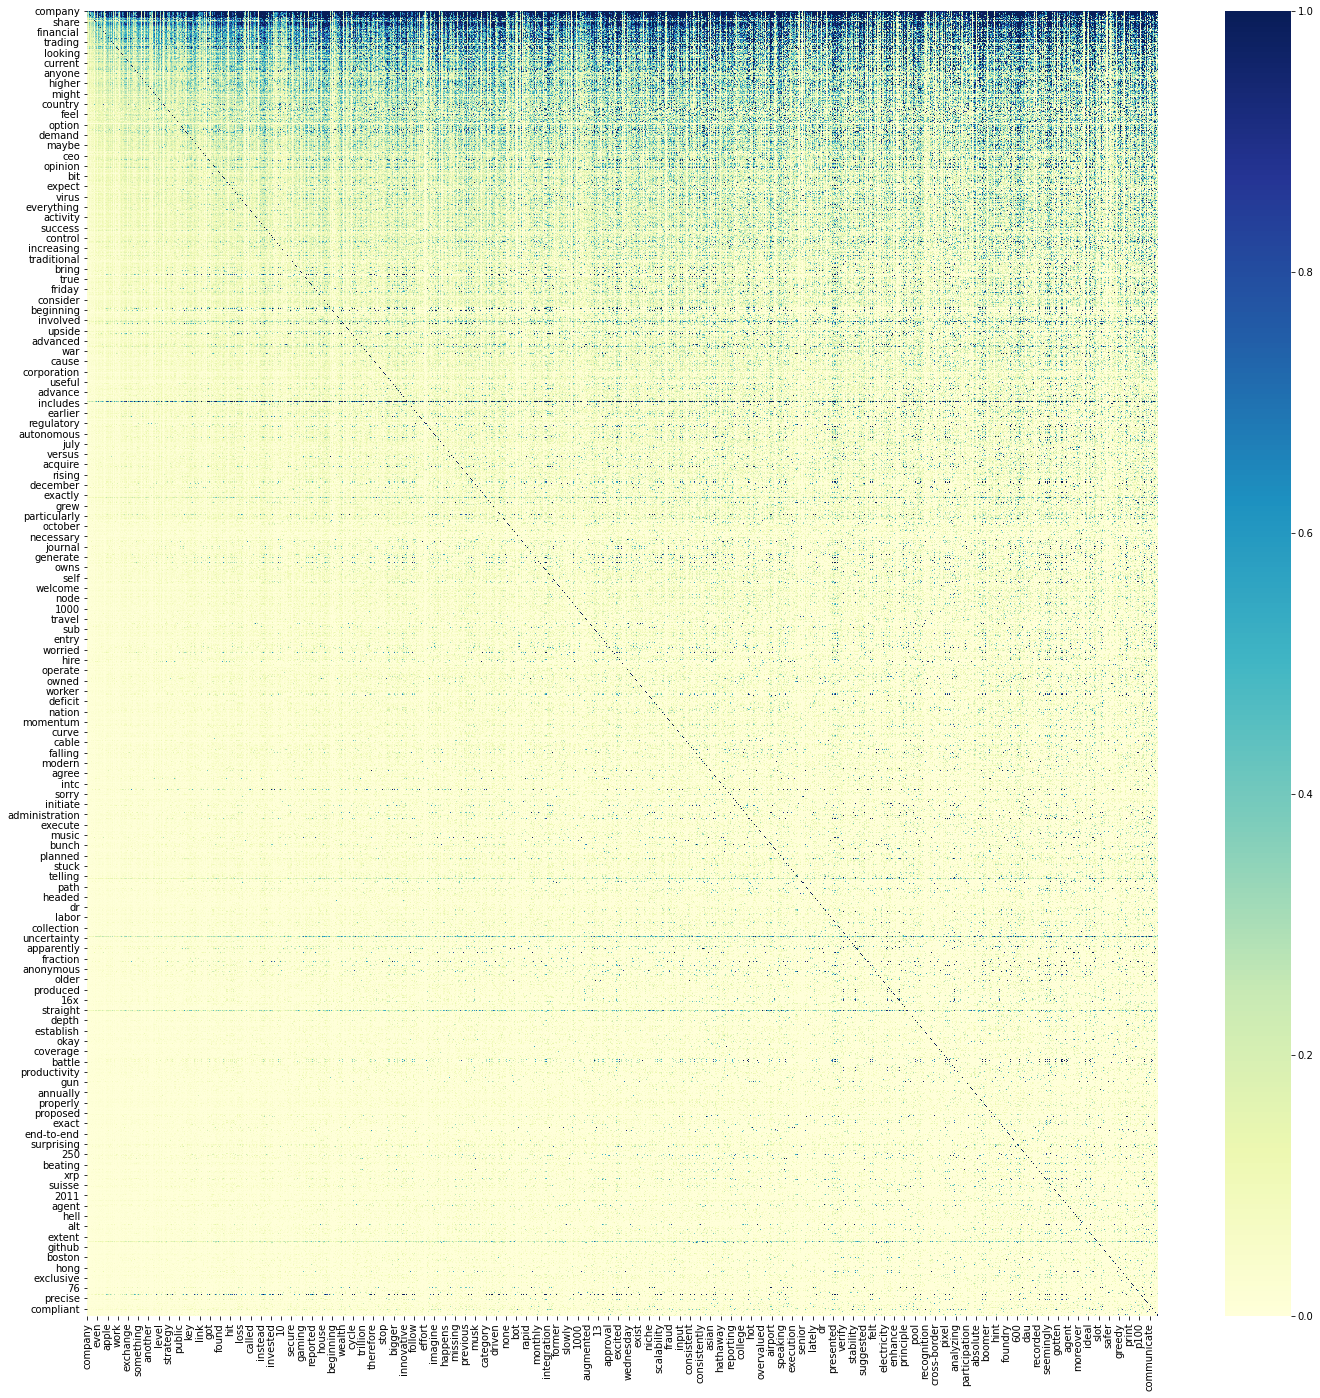

In [17]:
plt.figure(figsize=(24,24))
sns.heatmap(co_matrix_norm, vmin=0, vmax=1, cmap='YlGnBu')
plt.show()

In [18]:
corr = []
for i in co_matrix_norm.index:
    row = co_matrix_norm.loc[i]
    for j in co_matrix_norm.index:
        if i == j:
            continue
        else:
            if row[j] > 0:
                corr.append((i, j, row[j]*0.01))

In [19]:
graph = nx.Graph()
graph.add_weighted_edges_from(corr)

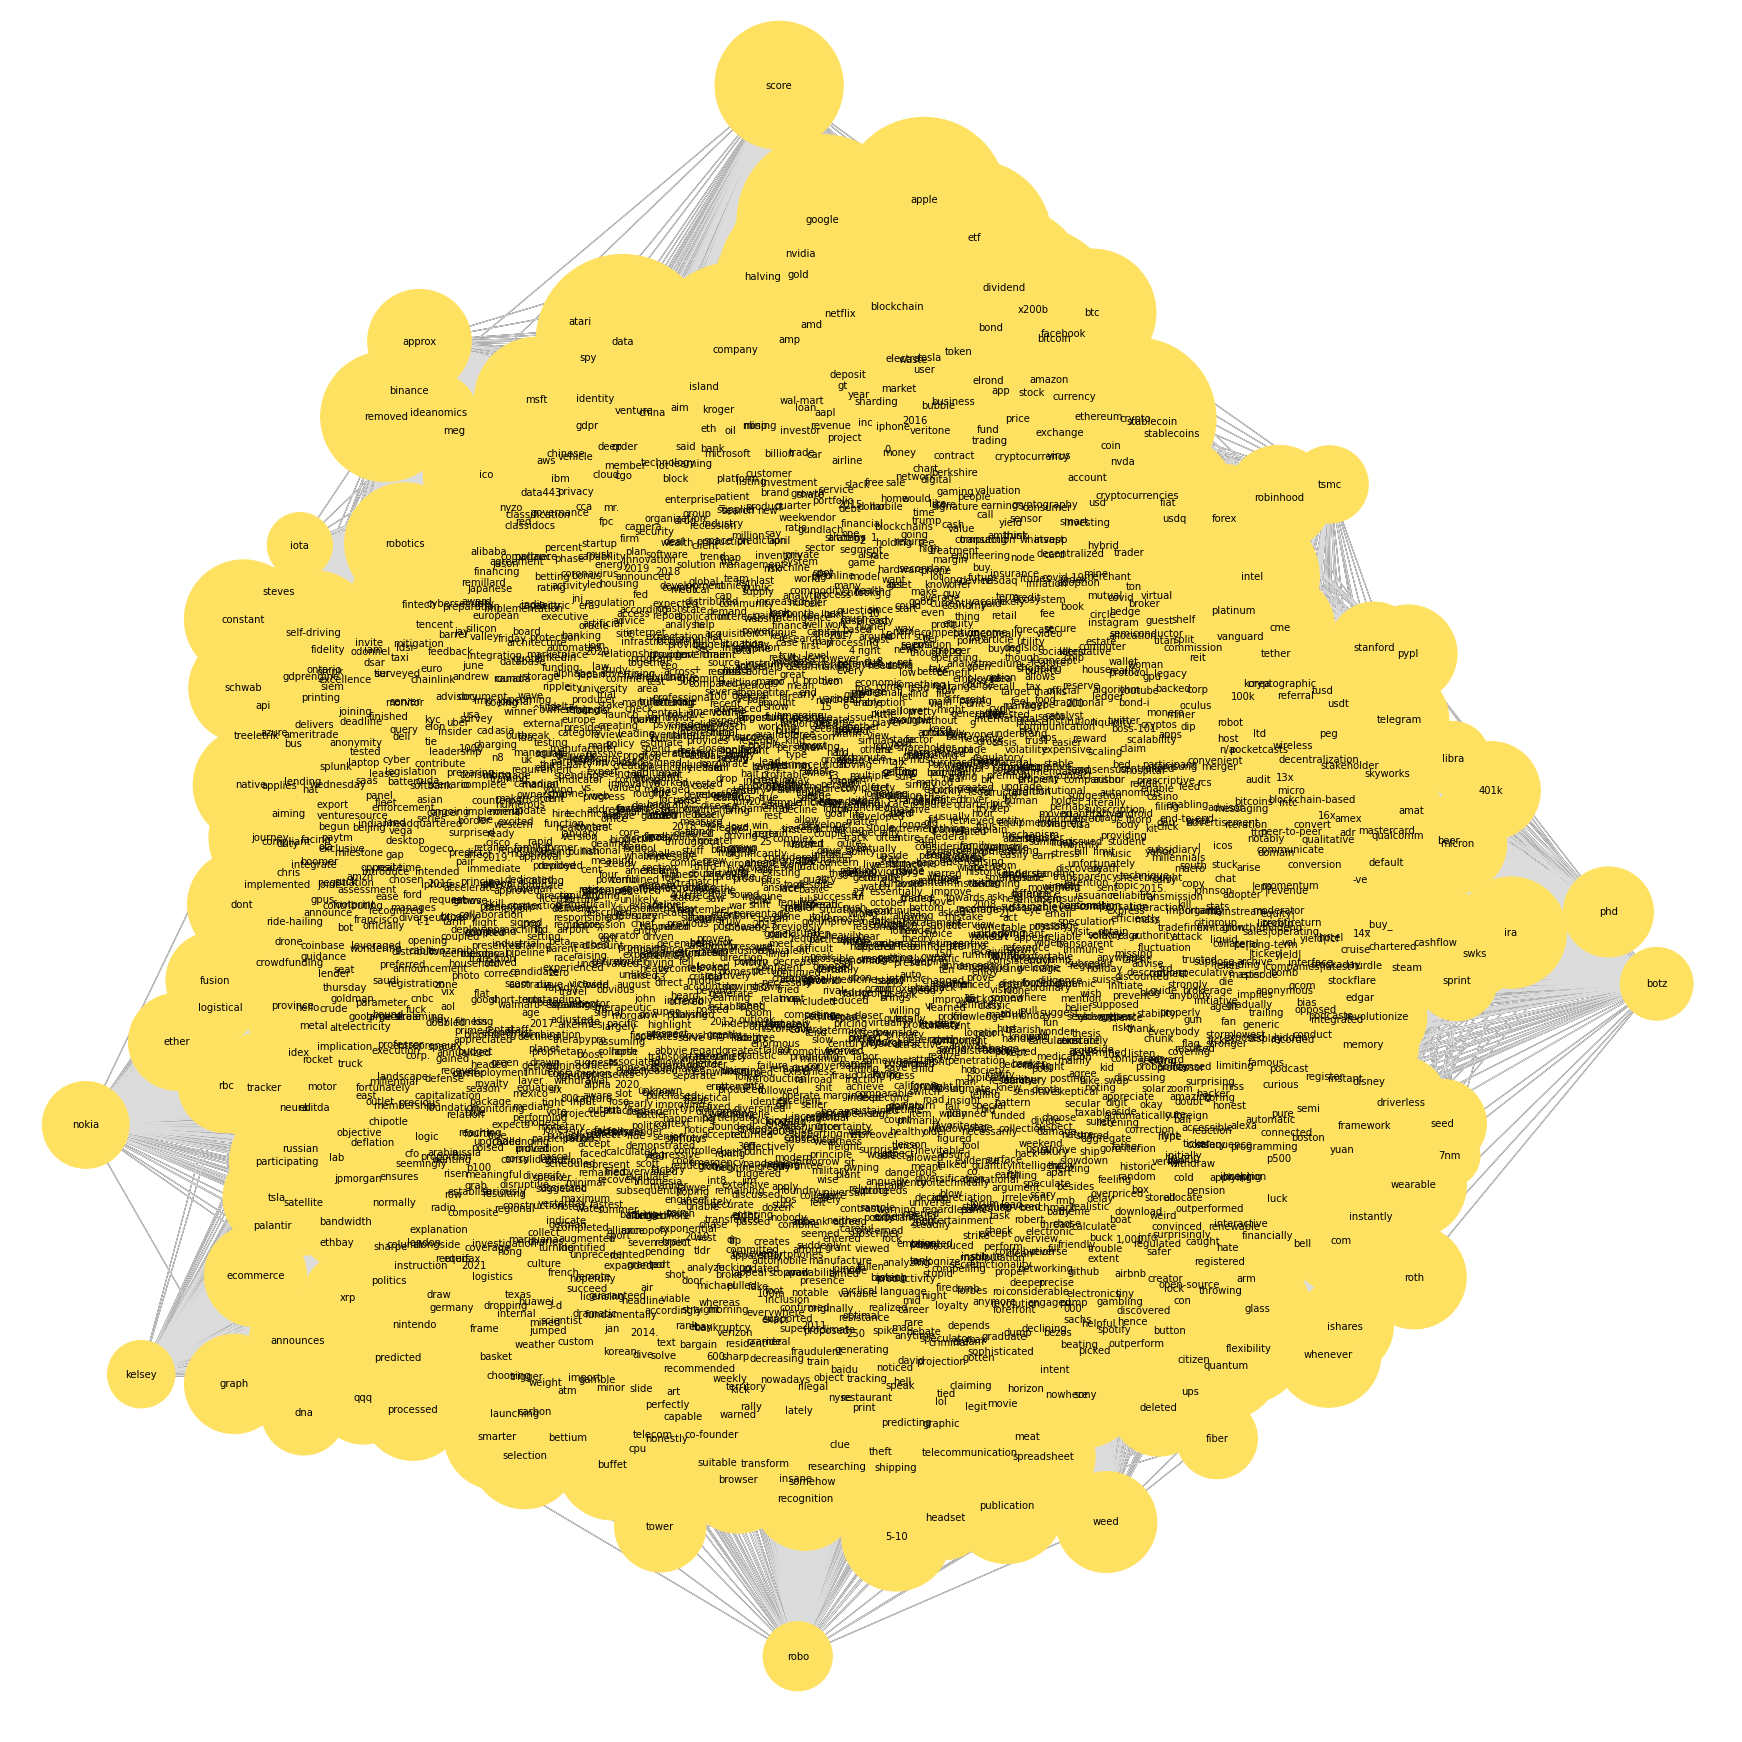

In [20]:
plt.figure(figsize=(24,24))
pos = nx.spring_layout(graph)
nx.draw(graph, pos, node_size = [val*10 for (node, val) in graph.degree()],node_color = '#FFE162')
nx.draw_networkx_labels(graph, pos, font_size = 10,alpha = 1)
nx.draw_networkx_edges(graph, pos, edge_color = '#DDDDDD', alpha = 1)
# plt.show()

In [21]:
freq = np.diagonal(co_matrix)
freq = pd.DataFrame(freq, co_matrix.index, columns=['freq'])
notexist = freq[freq['freq']==0]
freq = freq.drop(index=notexist.index)


freq_top10 = freq.sort_values(by='freq')

In [22]:
pf = freq_top10[-20:]


<BarContainer object of 20 artists>

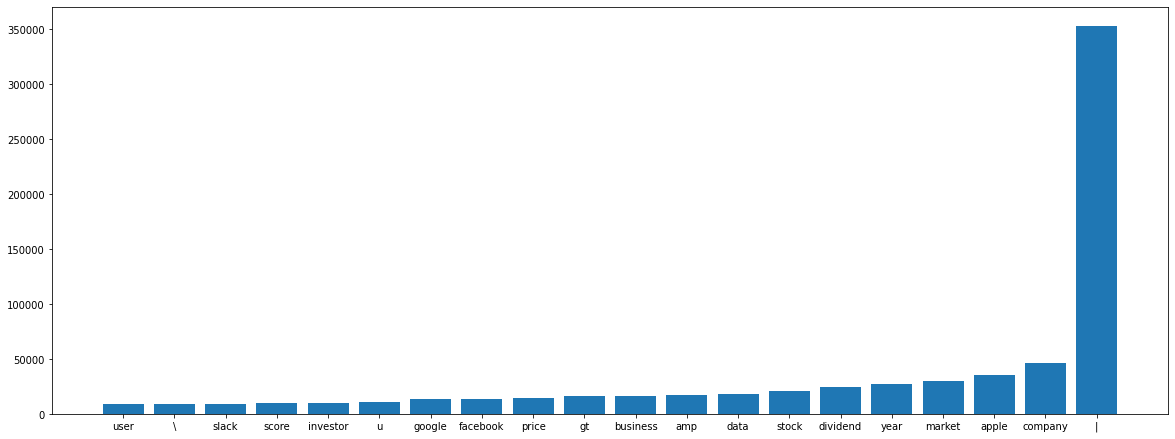

In [23]:
plt.figure(figsize=(20,7.5))
plt.bar(pf.index,pf['freq'].values)

In [24]:
def co_map_edge(symbolId, gap):
    co_edge_symbolId = []
    weight=[]
    row = co_matrix_norm.loc['%s'%symbolId]
    for j in co_matrix_norm.index:
        if row[j] == 1:
            weight.insert(0, 1)
        else:
            if row[j] >= gap:
                co_edge_symbolId.append(('%s'%symbolId, j, row[j] * 0.01))
                weight.append(row[j])
    return co_edge_symbolId, weight

In [25]:
def graph_one(C,symbolId,freq):
    plt.figure(figsize=(50,50))
    plt.rcParams['font.sans-serif'] = ['SimHei']   
    plt.rcParams['font.family']='sans-serif'
    pos = nx.spring_layout(C)
    nx.draw(C,pos,node_size=freq.values, font_family='sans-serif', node_color='#33FFFF')
    nx.draw_networkx_labels(C, pos, font_size = 2, font_family='sans-serif', alpha=1)
    nx.draw_networkx_edges(C, pos, edge_color='#DDDDDD', alpha=1)
    plt.savefig('%d'%symbolId+'_Co-occurrence map.png')
    plt.show()

In [26]:
def test(keyWord, gap):
    edge, weight = co_map_edge(keyWord, gap)
    freqKeyWord=[freq.loc[keyWord]['freq']]
    for i in edge:
        freqKeyWord.append(freq.loc[i[1]]['freq'])
    graph = nx.Graph()
    graph.add_weighted_edges_from(edge)
    plt.figure(figsize=(24,24))
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, node_size = [val*30 for (node, val) in graph.degree()],node_color = '#FFE162')
    nx.draw_networkx_labels(graph, pos, font_size = 20,alpha = 1)
    nx.draw_networkx_edges(graph, pos, edge_color = '#DDDDDD', alpha = 1)

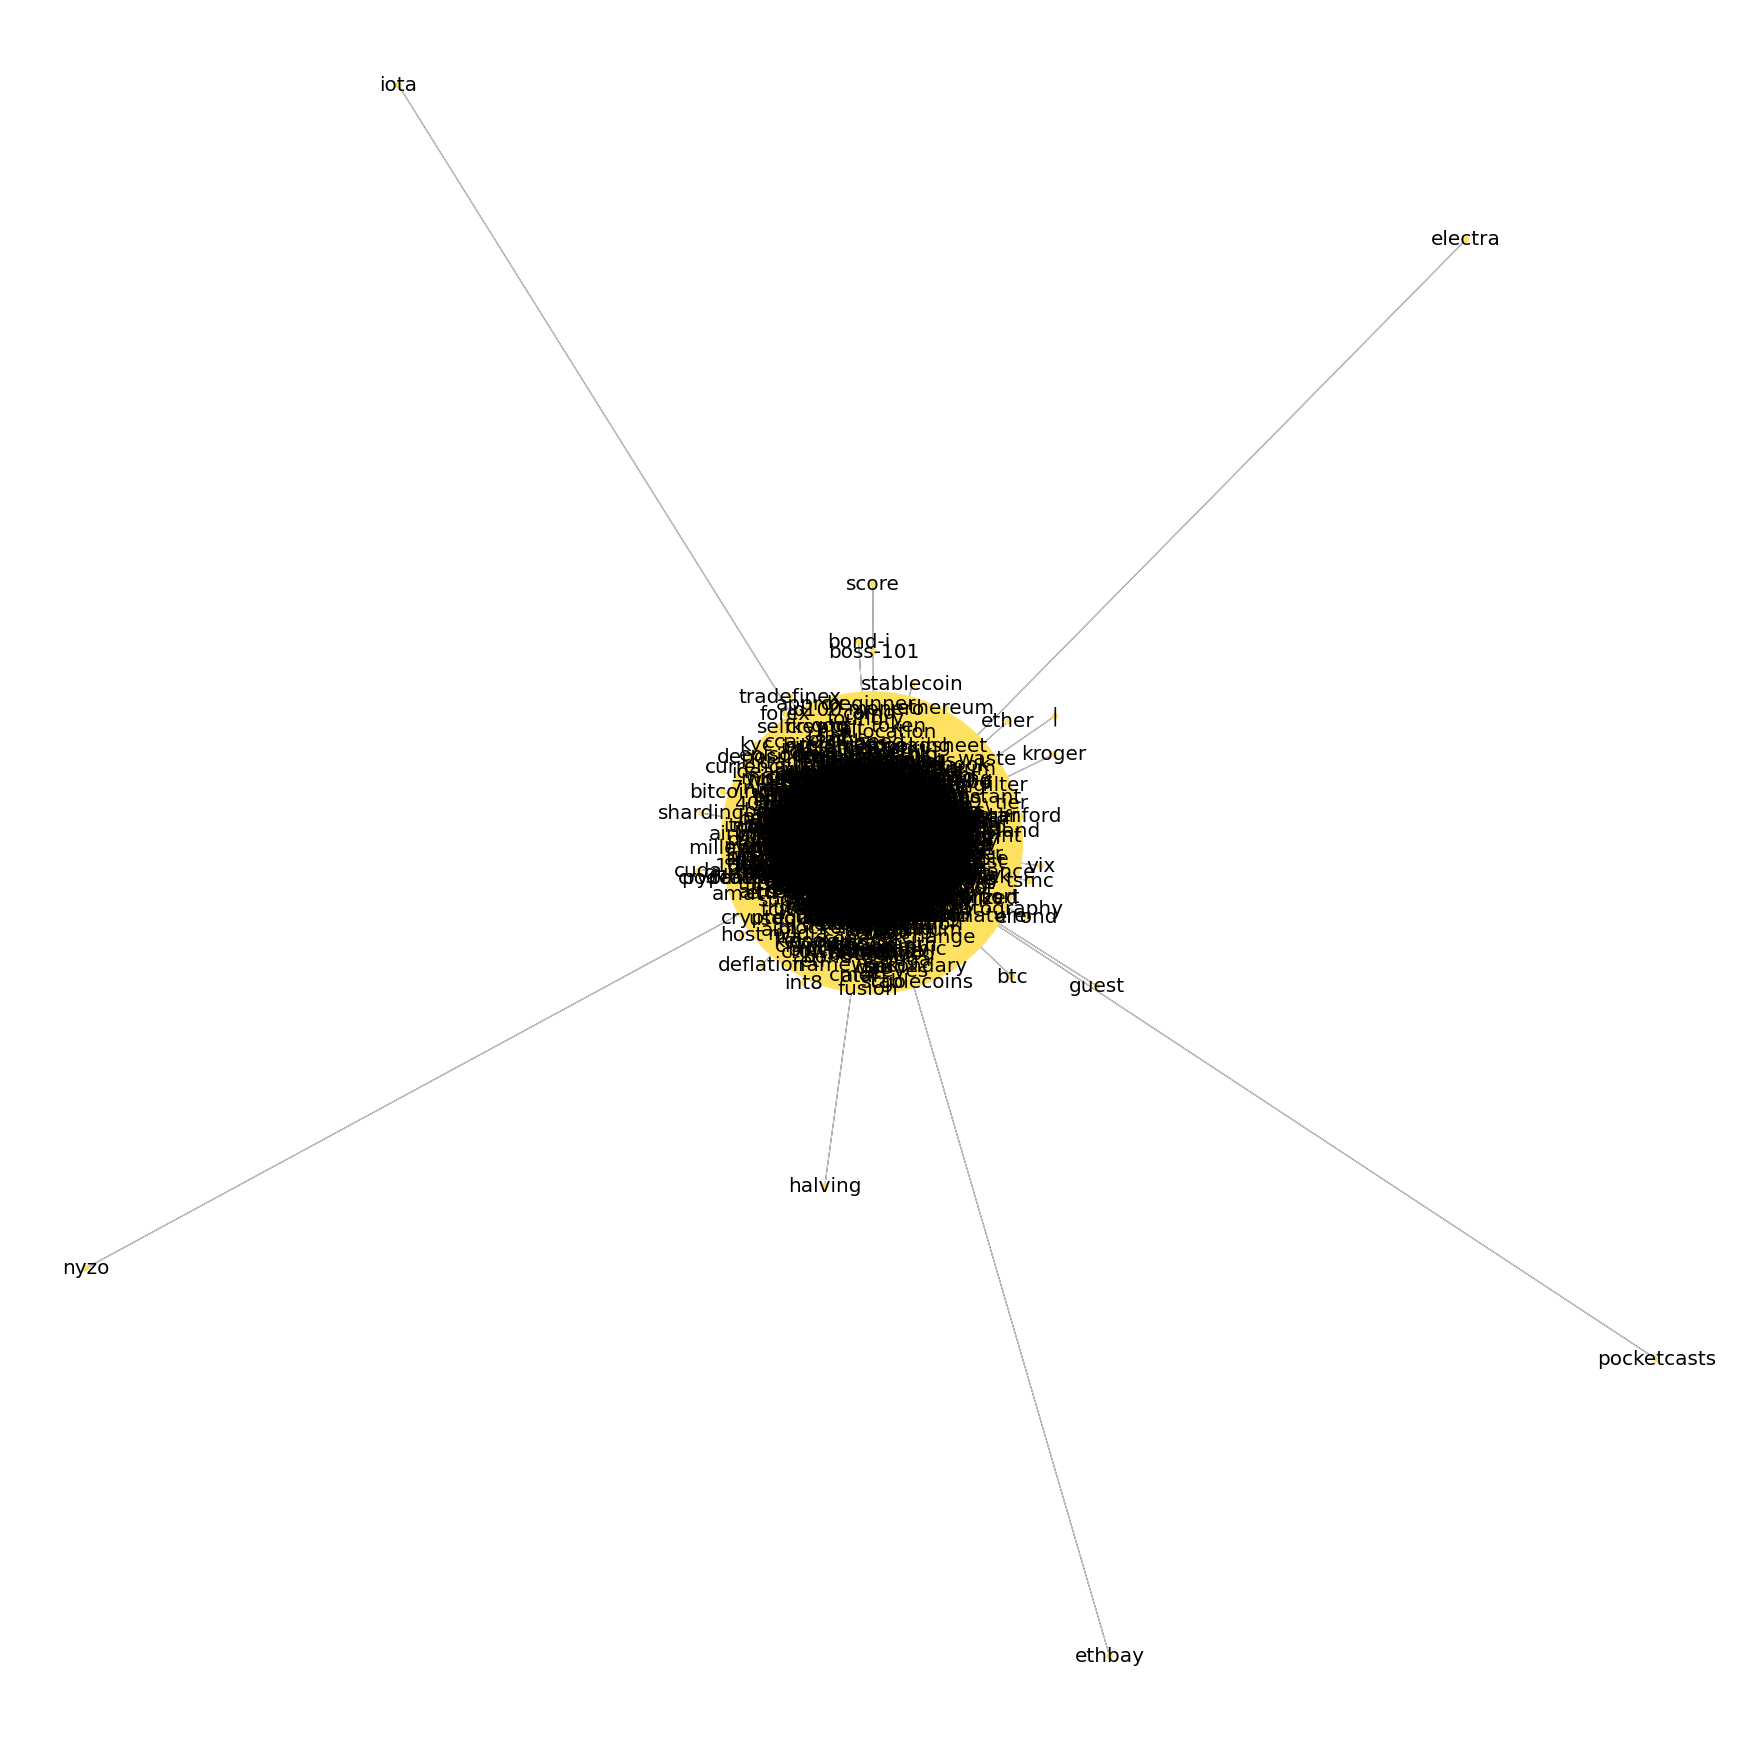

In [27]:
test('company', 0)

In [28]:
co_matrix_norm

company    market      year     stock      like       amp  \
company       1.000000  0.669049  0.917076  0.710672  1.180166  0.613662   
market        0.436721  1.000000  0.654808  0.582763  0.961909  0.423852   
year          0.540123  0.590820  1.000000  0.546939  1.032947  0.369821   
stock         0.325240  0.408584  0.424998  1.000000  0.671081  0.365454   
like          0.232898  0.290810  0.346109  0.289376  1.000000  0.209686   
...                ...       ...       ...       ...       ...       ...   
announces     0.001123  0.000927  0.001027  0.000472  0.000438  0.002128   
ride-hailing  0.007798  0.007479  0.010196  0.000472  0.009413  0.001120   
alongside     0.002743  0.003872  0.002054  0.000850  0.002518  0.001512   
median        0.012615  0.007115  0.021382  0.009109  0.021782  0.002184   
resistance    0.001620  0.005162  0.002861  0.005475  0.006349  0.001904   

                 would       one      time      data  ...  operational  \
company       0.997303  1.436066  1.197295  0.778678  ...     5.476190   
market        0.964041  1.148254  1.204298  0.267889  ...     4.714286   
year          0.797842  1.121597  1.124608  0.375140  ...     4.142857   
stock         0.602989  0.679829  0.737262  0.110555  ...     3.476190   
like          0.571188  0.691091  0.610360  0.140444  ...     2.047619   
...                ...       ...       ...       ...  ...          ...   
announces     0.001011  0.002138  0.000724  0.000213  ...     0.000000   
ride-hailing  0.000787  0.008411  0.007003  0.006127  ...     0.000000   
alongside     0.001910  0.007698  0.002415  0.001971  ...     0.000000   
median        0.004720  0.005987  0.011954  0.001971  ...     0.000000   
resistance    0.008765  0.010406  0.004468  0.000906  ...     0.000000   

                andrew  subsequently  licensing   taxable  announces  \
company       0.843137      6.888889   7.962963  2.194313   2.476190   
market        0.470588      5.666667   3.777778  0.810427   1.333333   
year          1.549020      3.370370   4.333333  0.682464   1.333333   
stock         1.588235      5.851852   3.222222  2.445498   0.476190   
like          1.901961      2.074074   1.925926  0.815166   0.190476   
...                ...           ...        ...       ...        ...   
announces     0.000000      0.000000   0.000000  0.000000   1.000000   
ride-hailing  0.000000      0.000000   0.000000  0.000000   0.000000   
alongside     0.000000      0.000000   0.000000  0.000000   0.000000   
median        0.000000      0.000000   0.000000  0.000000   0.000000   
resistance    0.039216      0.000000   0.037037  0.000000   0.000000   

              ride-hailing  alongside    median  resistance  
company           5.231884   6.047619  8.225352    1.744186  
market            3.275362   5.571429  3.028169    3.627907  
year              4.028986   2.666667  8.211268    1.813953  
stock             0.144928   0.857143  2.718310    2.697674  
like              1.246377   1.095238  2.802817    1.348837  
...                    ...        ...       ...         ...  
announces         0.000000   0.000000  0.000000    0.000000  
ride-hailing      1.000000   0.000000  0.000000    0.000000  
alongside         0.000000   1.000000  0.000000    0.000000  
median            0.000000   0.000000  1.000000    0.000000  
resistance        0.000000   0.000000  0.000000    1.000000  

[3041 rows x 3041 columns]